In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics

In [ ]:
import h2o

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Analysis and Visualization

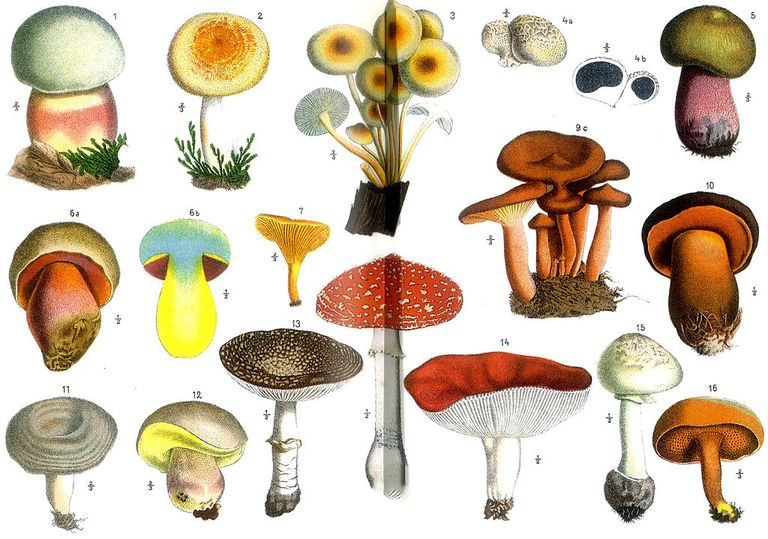

In [ ]:
df = pd.read_csv('../input/mushroom-classification/mushrooms.csv')
df.head()

In [ ]:
mushrooms_report = ProfileReport(df)

In [ ]:
mushrooms_report

## Early data conclusiones:

All the variables are categorical so we will have to manage it.

- **veil-type**:  is a constant variable so we can delete it
- **odor**: is highly correlated with the class so we should take care
- **correlation**: there is high correlation between *veil-color*, *gill-attachment* and *stalk-color-above-ring*

In [ ]:
# we can delete *veil-type*
df = df.drop('veil-type', axis=1)
df.shape

In [ ]:
fig = px.histogram(df, x='class', color='class', color_discrete_sequence=px.colors.qualitative.Plotly[3:])
fig.show()

As we can see, both classes are equally distributed and balanced.

# H2O Classification

In this section we will train different models and compare the performance.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['class'])

In [ ]:
model_df = df.copy()
model_df['class'] = y
model_df.head()

## XGBoost

In [ ]:
from h2o.estimators import H2OXGBoostEstimator

In [ ]:
h2o.init()

In [ ]:
hf = h2o.H2OFrame(model_df)

In [ ]:
hf['class'] = hf['class'].asfactor()
predictors = hf.drop('class').columns
response = 'class'

In [ ]:
# Split into train and test
train, valid = hf.split_frame(ratios=[.8], seed=1234)

In [ ]:
# Build and train the model:
mushroom_xgb = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=1234,
                                  nfolds=5,
                                  )

In [ ]:
# Train the model
mushroom_xgb.train(x=predictors,
                  y=response,
                  training_frame=train,
                  validation_frame=valid)

In [ ]:
mushroom_xgb.metric(metric='accuracy', valid=True)

In [ ]:
mushroom_xgb.model_performance(valid=True)

### Variable importance

Here we can see wich variables are more important for the model and have higher relevance in the class.

**As we saw at the bigining, *odor* is the highest correlated variable with the class**

In [ ]:
mushroom_xgb.varimp_plot(num_of_features=10)

In [ ]:
mushroom_xgb.shap_summary_plot(valid)

# AutoML

In this section we will try H2O AutoML and watch the best model performance.

Remember that all models are trined using cross-validation.

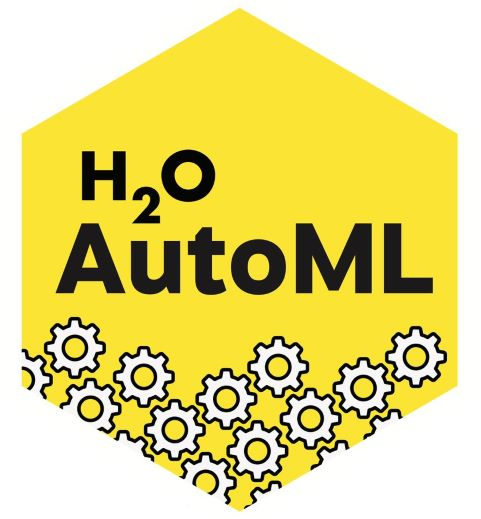

In [ ]:
from h2o.automl import H2OAutoML

In [ ]:
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=300,
    seed=1
)

In [ ]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=train,
        validation_frame=valid
)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
lb = lb.as_data_frame()
lb['model_type'] = lb['model_id'].apply(lambda x: x.split('_')[0])
fig = px.bar(
    lb, 
    x='model_id',
    y='auc',
    color='model_type'
)
fig.update_yaxes(range=[0.999, 1])
fig.show()


As we can see, all the models have really high AUC. **H2O AutoML is awesome**

In [ ]:
print('The model performance in Accuracy: {}'.format(aml.leader.accuracy(valid=True)))
print('The model performance in AUC: {}'.format(aml.leader.auc(valid=True)))

In [ ]:
aml.leader.varimp_plot(num_of_features=10)

# Classification Models Comparisson

Now lets try to use the core classification methods. With label encoder and tipical PCA.

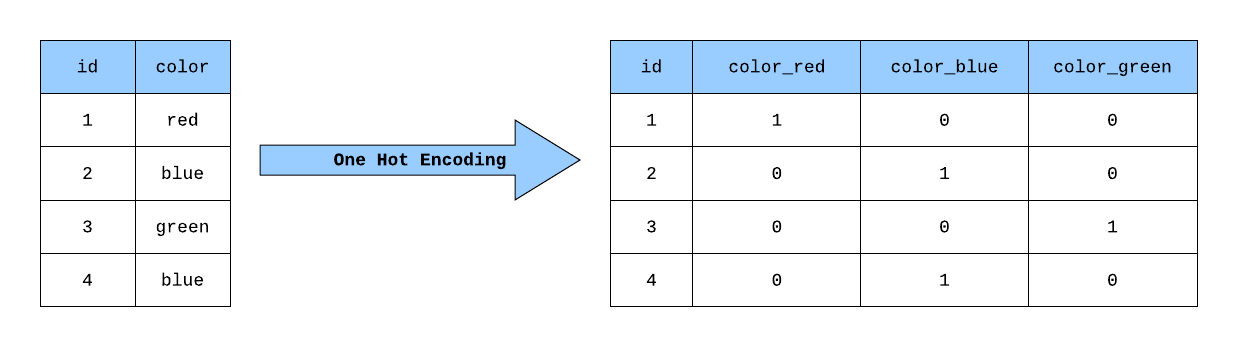

In [ ]:
# Label encoding y - dependent variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['class'])

In [ ]:
# One hot encoding independent variable x

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
x = ohe.fit_transform(df.drop('class', axis=1)).toarray()
x.shape

## Principal Component Analysis

Now we have 116 binary variables so we can try to some feature selection process.

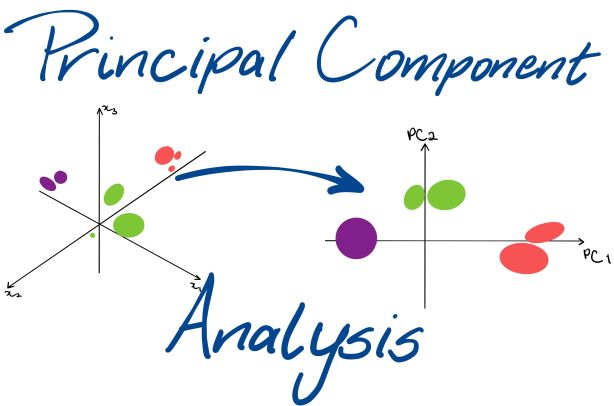

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(x)

In [ ]:
covariance = pca.get_covariance()
explained_variance = pca.explained_variance_

In [ ]:
fig = go.Figure(go.Bar(
    x=list(range(30)), 
    y=explained_variance[:30],
))
fig.update_layout(
    xaxis_title='Principal components',
    yaxis_title='Explained variance ratio',
    legend_title='individual explained variance',
)
fig.show()

As we can see, only the top (maybe 9 variables?) are the most importante. So we can just hold those ones.

In [ ]:
pca = PCA(n_components=9)
x_pca = pca.fit_transform(x)

In [ ]:
x_pca.shape

In [ ]:
# Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.2, random_state=1234)

In [ ]:
# Create a list for the accuracy of all the models we are going to see
acscore = []

## Logistic Regression

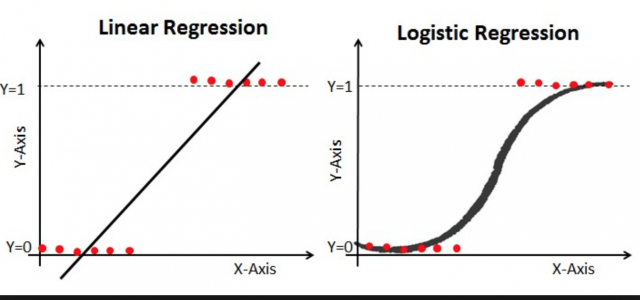

In [ ]:
# Training the Logistic Regression Model on the Training set
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=1234)
classifier.fit(x_train, y_train)

In [ ]:
# Predicting the test set
y_pred = classifier.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
acscore.append(accuracy)
print(accuracy)

## Naive Bayes

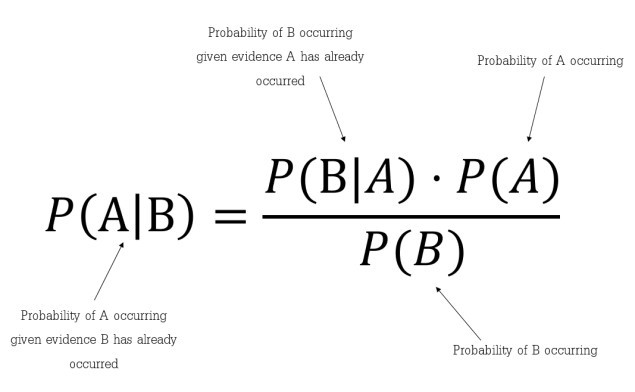

In [ ]:
# Training the Naive Bayes Classification model
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(x_train, y_train)

In [ ]:
# Predicting the test set
y_pred = classifier.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
acscore.append(accuracy)
print(accuracy)

## XGBoost

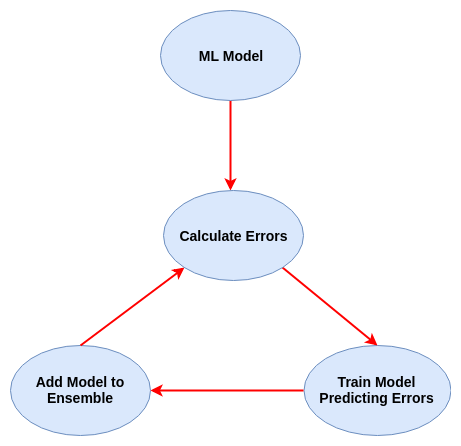

In [ ]:
# Training the XGBoost Classification model
from xgboost import XGBClassifier

classifier = XGBClassifier()
classifier.fit(x_train,y_train)

In [ ]:
# Predicting the test set
y_pred = classifier.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
acscore.append(accuracy)
print(accuracy)

In [ ]:
# Training the Random Forest Classification model
from sklearn.ensemble import RandomForestClassifier

# Lets use a standard 60 n_erstimatoprs
classifier = RandomForestClassifier(criterion='entropy', random_state=1234, n_estimators=60)
classifier.fit(x_train, y_train)

In [ ]:
# Predicting the test set
y_pred = classifier.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
acscore.append(accuracy)
print(accuracy)

In [ ]:
models_names = ['LogisticRegression', 'NaiveBayes', 'XGBoost', 'RandomForest']

In [ ]:
fig = go.Figure(go.Bar(
    x=models_names,
    y=acscore,
))
fig.show()

# Conclusions

As we saw, this a very easy to solve problem and we  solved it with really high accuracy and AUC.

**The best models are XGBoost as we can see in the state of the art**.

We have checked that **H2O has and awsome performance and really fast**. Also, you can check the Sparkling Water parallelization for bigger datasets: [H2O original documentation](https://www.h2o.ai/blog/how-sparkling-water-brings-h2o-to-spark/)